/var/folders/hr/2t7hsj753qg3n1q7zbnr625m0000gn/T/ipykernel_98267/2934484614.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_frame['start_x'] = transform_x_coordinates(selected_frame['x'])
/var/folders/hr/2t7hsj753qg3n1q7zbnr625m0000gn/T/ipykernel_98267/2934484614.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_frame['start_y'] = transform_y_coordinates(selected_frame['y'])


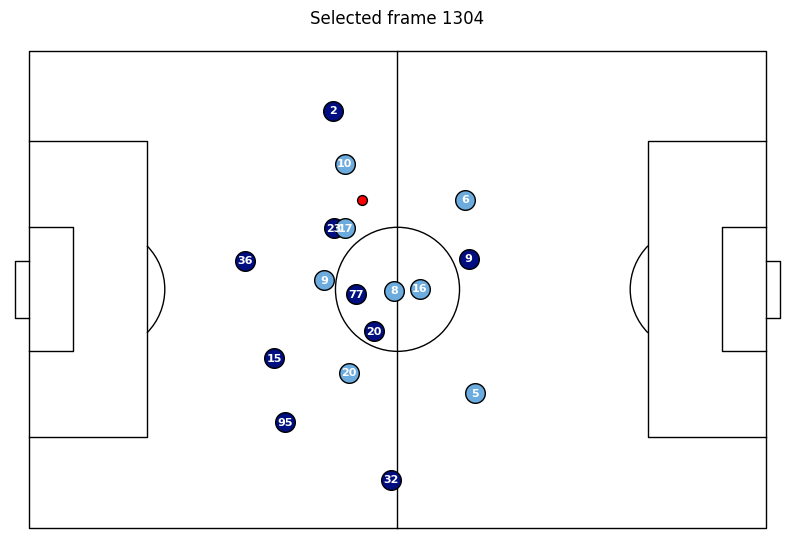

In [1]:
"""
 Visualize tracking data
 
 Given a match ID and a frame, this code shows the positions of the players on
 the pitch.
 
 Ball is shown in red.
 
"""

import os  # 用于处理文件和目录操作
import pandas as pd  # 导入 pandas 用于数据操作
from matplotlib import pyplot as plt  # 导入 matplotlib 来绘制图形
from mplsoccer import Pitch  # 从 mplsoccer 导入 Pitch 用于绘制球场

# 定义球场的长度和宽度
pitch_length = 105
pitch_width = 68

def transform_x_coordinates(x):
    """
    将 x 坐标从原始单位转换到百分比形式（0-100）。
    """
    return x / pitch_length * 100

def transform_y_coordinates(x):
    """
    将 y 坐标从原始单位转换到百分比形式（0-100），并翻转 y 轴。
    """
    return 100 - (x / pitch_width * 100)

# 设置比赛的 ID
match_id = 18768058

# 从 parquet 文件加载比赛的跟踪数据
# parquet 文件是一种用于存储表格数据的列式存储格式
# "Data/{match_id}_tracks.parquet" 文件路径包含跟踪数据
df_tracking = pd.read_parquet(f"Data/{match_id}_tracks.parquet")

# 选择特定的帧
# 从跟踪数据中选择第 300 行的帧号和比赛阶段
frame, period = df_tracking.iloc[300][['frame', 'period']]
# 根据选择的帧号和比赛阶段过滤出该帧的数据
selected_frame = df_tracking[(df_tracking['frame'] == frame) & (df_tracking['period'] == period)]

# 将 x 和 y 坐标转换到 wyscout 系统的单位
selected_frame['start_x'] = transform_x_coordinates(selected_frame['x'])
selected_frame['start_y'] = transform_y_coordinates(selected_frame['y'])

# 设置队伍的颜色
team_colors = {
    'Manchester City': '#6cabdd',  # 曼彻斯特城队的颜色
    'Inter': '#010E80',  # 国际米兰队的颜色
}

# 创建一个 10x7 英寸大小的图形和子图
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# 初始化球场
pitch = Pitch(pitch_type="wyscout",  # 使用 wyscout 类型的球场
              goal_type='box',  # 使用矩形球门
              pitch_color="w",  # 设置球场颜色为白色
              linewidth=1,  # 线宽为 1
              spot_scale=0,  # 不绘制点球点
              line_color="k",  # 线条颜色为黑色
              line_zorder=1)  # 设置线条的绘制顺序

# 绘制球场
pitch.draw(ax)

# 为每个队伍添加球员的位置
for team, players in selected_frame.groupby('team_name'):
    # 绘制每个球员的位置点
    pitch.scatter(
        players['start_x'],  # x 坐标
        players['start_y'],  # y 坐标
        color='r' if team == 'ball' else team_colors.get(team, 'k'),  # 球为红色，其它队伍根据 team_colors 设置
        ec='k',  # 设置边框颜色为黑色
        ax=ax,  # 指定绘制的坐标轴
        lw=1,  # 边框宽度为 1
        zorder=3 if team == 'ball' else 2,  # 设置绘制顺序，球优先级最高
        s=50 if team == 'ball' else 200,  # 球大小为 50，其它球员为 200
    )

    # 为球员的位置添加球衣号码，忽略球的位置
    for idx, row in players[players['team_name'] != 'ball'].iterrows():
        pitch.annotate(row['jersey_number'],  # 球衣号码
                       xy=(row['start_x'], row['start_y']),  # 位置坐标
                       c='w',  # 文字颜色为白色
                       va='center',  # 文字垂直对齐方式为居中
                       zorder=4,  # 设置绘制顺序
                       ha='center',  # 文字水平对齐方式为居中
                       size=8,  # 字体大小为 8
                       weight='bold',  # 字体加粗
                       alpha=1,  # 透明度为 1
                       ax=ax)  # 指定绘制的坐标轴

# 为图形添加标题
ax.set_title(f"Selected frame {frame}")

# 创建输出目录并保存图像
os.makedirs("outputs", exist_ok=True)  # 如果不存在，则创建 "outputs" 目录
fig.savefig(f"outputs/freeze_frame_{frame}_{period}.jpg", format='jpg', dpi=200, facecolor=fig.get_facecolor())  # 保存图像到指定目录
